In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

In [3]:
# Load and preprocess the data
daily_data = pd.read_csv(r"SN_d_tot_V2.0.csv", delimiter=';', header=None)
daily_data.columns = ["Year", "Month", "Day", "FractionalYear", "SunspotNumber", "StdDev", "Observations", "Indicator"]
daily_data = daily_data[daily_data["SunspotNumber"] != -1]  # Remove missing values

In [5]:
# Create a datetime column
daily_data['Date'] = pd.to_datetime(daily_data[['Year', 'Month', 'Day']])
daily_data = daily_data[['Date', 'SunspotNumber']].rename(columns={'Date': 'ds', 'SunspotNumber': 'y'})

In [7]:
# Replace zero values and apply log transformation
daily_data['y'] = daily_data['y'].replace(0, 1e-6)
daily_data['y'] = daily_data['y'].apply(lambda x: np.log(x + 1e-6))
daily_data = daily_data[daily_data['y'] > 0]  # Keep only positive values

In [9]:
# Initialize and fit the Prophet model
daily_model = Prophet()
daily_model.fit(daily_data)

21:03:39 - cmdstanpy - INFO - Chain [1] start processing
21:04:56 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
# Create future dataframes for predictions
future_daily = daily_model.make_future_dataframe(periods=365)


In [11]:
# Predict for the next 365 days
forecast_daily = daily_model.predict(future_daily)

In [12]:
# Predict for 100 and 200 days
forecast_daily_100 = daily_model.predict(daily_model.make_future_dataframe(periods=100))
forecast_daily_200 = daily_model.predict(daily_model.make_future_dataframe(periods=200))

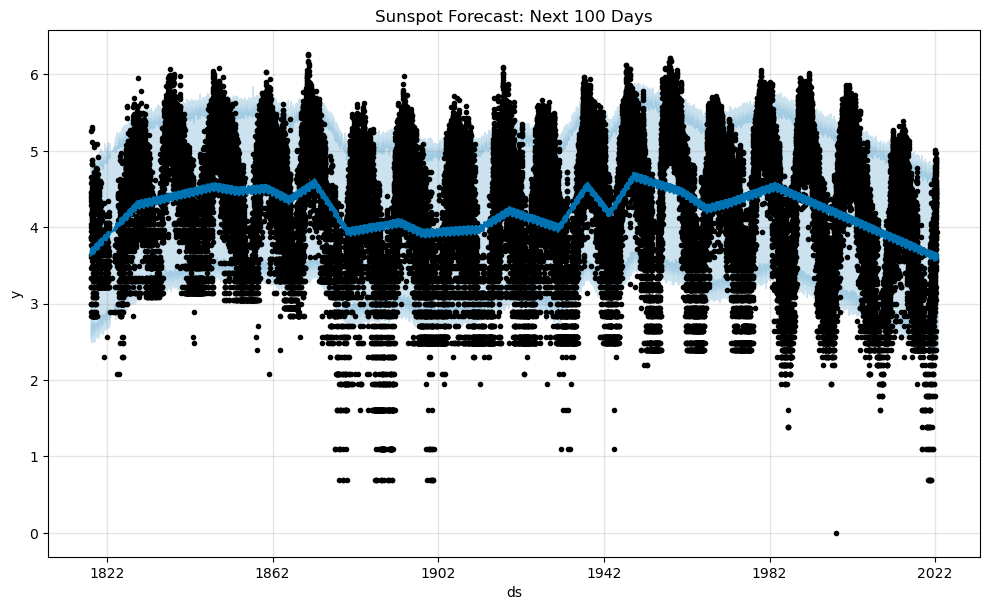

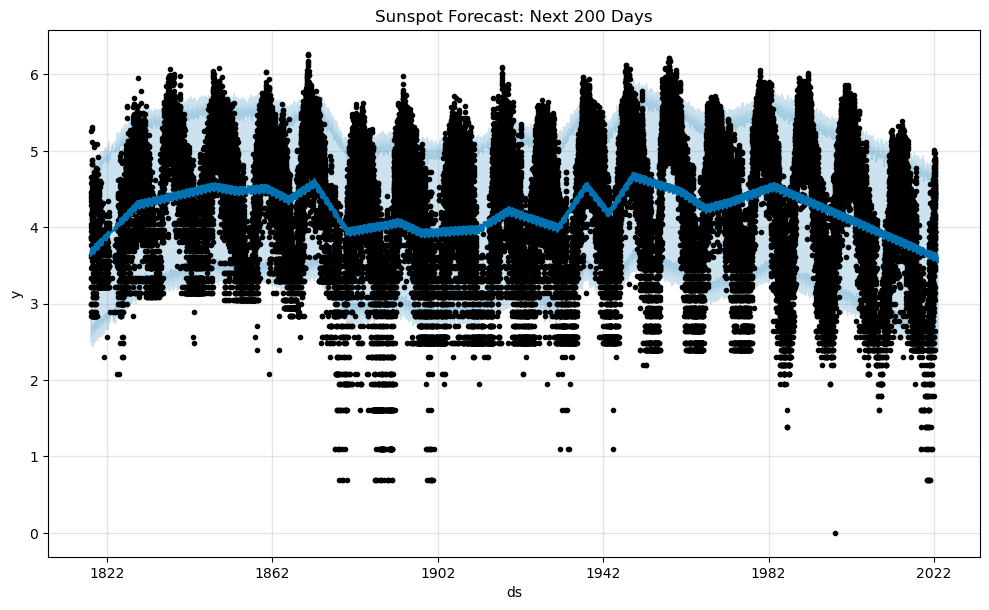

In [13]:
# Visualize predictions for each forecast
for forecast, days in zip([forecast_daily_100, forecast_daily_200], [100, 200]):
    fig = daily_model.plot(forecast)
    plt.title(f"Sunspot Forecast: Next {days} Days")
    plt.show()


In [14]:
# Print predicted values for the next 100, 200, and 365 days
for forecast, days in zip([forecast_daily_100, forecast_daily_200, forecast_daily], [100, 200, 365]):
    print(f"Predicted values for the next {days} days:")
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(days))

Predicted values for the next 100 days:
              ds      yhat  yhat_lower  yhat_upper
59985 2022-05-01  3.653769    2.589559    4.785031
59986 2022-05-02  3.656339    2.544111    4.709474
59987 2022-05-03  3.650645    2.669674    4.692626
59988 2022-05-04  3.659089    2.569825    4.692641
59989 2022-05-05  3.648879    2.546002    4.783207
...          ...       ...         ...         ...
60080 2022-08-04  3.593094    2.466577    4.715441
60081 2022-08-05  3.596886    2.483574    4.671682
60082 2022-08-06  3.601450    2.455776    4.622849
60083 2022-08-07  3.607554    2.520614    4.744776
60084 2022-08-08  3.611263    2.538529    4.643319

[100 rows x 4 columns]
Predicted values for the next 200 days:
              ds      yhat  yhat_lower  yhat_upper
59985 2022-05-01  3.653769    2.540881    4.779288
59986 2022-05-02  3.656339    2.561591    4.780095
59987 2022-05-03  3.650645    2.586984    4.749879
59988 2022-05-04  3.659089    2.576493    4.766763
59989 2022-05-05  3.648879   

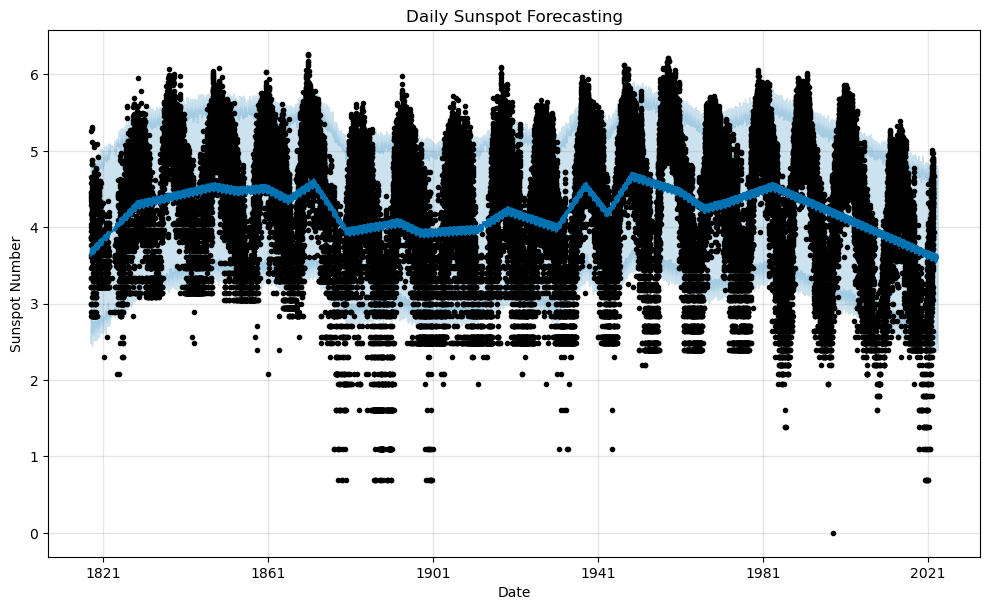

In [15]:
# Final visualization of the daily forecast
fig_final = daily_model.plot(forecast_daily)
plt.title("Daily Sunspot Forecasting")
plt.xlabel("Date")
plt.ylabel("Sunspot Number")
plt.show()

In [16]:
# Fit the model with additional seasonality
daily_model = Prophet(growth='linear', changepoint_prior_scale=0.05)
daily_model.add_seasonality(name='yearly', period=365.25, fourier_order=10)


In [17]:
# Fit and predict again
daily_model.fit(daily_data)
forecast_daily = daily_model.predict(future_daily)


21:06:16 - cmdstanpy - INFO - Chain [1] start processing
21:07:32 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Calculate metrics for the last 100 days
y_true = daily_data['y'].tail(100)
y_pred = forecast_daily['yhat'][-100:]

In [19]:
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Metrics for the last 100 days: MAE: {mae}, MAPE: {mape}, R²: {r2}")

Metrics for the last 100 days: MAE: 0.6740107878084415, MAPE: 0.1582095763430054, R²: -1.1197935064342102
